In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_tuner as kt

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
split = ['train+test[:50%]', 'test[50%:]']
(data_train, data_test), data_info = tfds.load(name='fashion_mnist', split=split, 
                                               as_supervised=True, shuffle_files=True, with_info=True)

classes = data_info.features["label"].names 

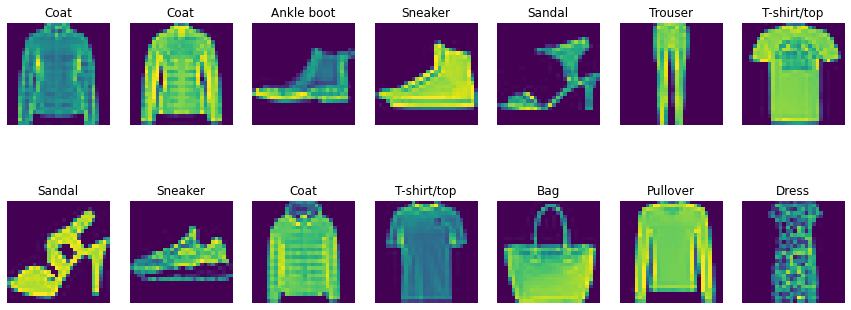

In [3]:
plt.figure(figsize=(15,6))

rows = 2
for i,tfd in zip(range(14),data_train):
    plt.subplot(rows,7,i+1)
    plt.title(classes[tfd[1].numpy()])
    plt.axis('off')
    plt.imshow(tfd[0])

In [4]:
print('Classes: ', classes)
print('Total Number of Classes: {}'.format(len(classes)))
print('Total Number of Training Images: {}'.format(len(data_train)))
print('Total Number of Validation Images: {}'.format(len(data_test)))

Classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Total Number of Classes: 10
Total Number of Training Images: 65000
Total Number of Validation Images: 5000


In [5]:
def to_array(data):
    x, y = [], []
    for i,l in data:
        x.append(i.numpy())
        y.append(l.numpy())
    X = np.asarray(x)
    Y = np.asarray(y)
    return X,Y

In [6]:
def normalize_img(image,label):
    return tf.cast(image,tf.float32)/255.,label

In [7]:
data_train = data_train.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
(X_train,Y_train) = to_array(data_train)

In [9]:
data_train = data_train.cache().batch(32).shuffle(len(data_train)).prefetch(buffer_size=tf.data.AUTOTUNE)
data_test = data_test.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
def _model(activation = 'relu',optimizer='rmsprop',learning_rate=0.01):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(256, activation=activation),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(64, activation=activation),
        tf.keras.layers.Dense(32, activation=activation),
        tf.keras.layers.Dense(len(classes),activation='softmax')
    ])
    
    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(build_fn=_model, verbose=0)

C:\Users\User\AppData\Local\Temp\ipykernel_10464\4093626626.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=_model, verbose=0)


In [12]:
optimizer = ['rmsprop','adam','sgd']
learning_rate = [0.001, 0.01, 0.1]
activation = ['relu', 'sigmoid','linear']

In [13]:
param_grid = dict(activation=activation,optimizer=optimizer,learning_rate=learning_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train, Y_train)

In [14]:
print("Best parameters: {}".format(grid_result.best_params_))

Best parameters: {'activation': 'relu', 'learning_rate': 0.001, 'optimizer': 'adam'}


In [15]:
grid_result.score(X_train, Y_train)

0.8601538461538462

In [16]:
model = _model(optimizer=grid_result.best_params_['optimizer'],
                activation=grid_result.best_params_['activation'],
                learning_rate=grid_result.best_params_['learning_rate'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 10)               

In [18]:
trainHistory = model.fit(data_train, epochs=15)

Epoch 1/15
2032/2032 [==============================] - 7s 3ms/step - loss: 0.5100 - accuracy: 0.8145
Epoch 2/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.3749 - accuracy: 0.8630
Epoch 3/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.3408 - accuracy: 0.8757
Epoch 4/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.3170 - accuracy: 0.8830
Epoch 5/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.2971 - accuracy: 0.8904
Epoch 6/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.2845 - accuracy: 0.8948
Epoch 7/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.2719 - accuracy: 0.8984
Epoch 8/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.2600 - accuracy: 0.9027
Epoch 9/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.2520 - accuracy: 0.9047
Epoch 10/15
2032/2032 [==============================] - 6s 3ms/step - loss: 0.243

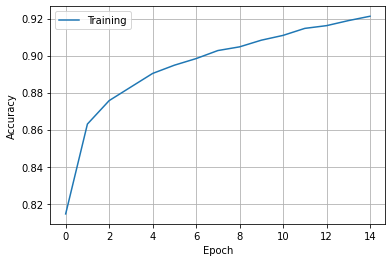

In [19]:
plt.plot(trainHistory.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [20]:
model.evaluate(data_test, verbose=2)

157/157 - 0s - loss: 48.9604 - accuracy: 0.8708 - 454ms/epoch - 3ms/step


[48.96037673950195, 0.8708000183105469]

In [21]:
(_,y_true) = to_array(data_test.unbatch())
y_pred = np.argmax(model.predict(data_test),axis=-1)

In [22]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       489
           1       0.96      0.97      0.97       513
           2       0.85      0.70      0.77       478
           3       0.92      0.81      0.86       510
           4       0.68      0.91      0.78       518
           5       0.98      0.93      0.95       494
           6       0.75      0.65      0.69       519
           7       0.96      0.93      0.94       484
           8       0.97      0.97      0.97       496
           9       0.90      0.98      0.94       499

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000



In [23]:
pd.DataFrame(confusion_matrix(y_true,y_pred))

,0,1,2,3,4,5,6,7,8,9
0,425,4,6,12,0,1,37,0,4,0
1,2,500,0,7,3,0,1,0,0,0
2,8,2,336,3,91,0,36,0,2,0
3,17,8,2,413,57,0,12,0,1,0
4,0,1,20,4,470,0,23,0,0,0
5,0,0,0,0,1,458,0,8,2,25
6,78,2,30,8,61,0,335,0,5,0
7,0,0,0,0,0,5,0,449,0,30
8,5,2,1,0,4,1,2,2,479,0
9,0,0,0,0,0,1,1,8,0,489
